In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 2: Simmy sims

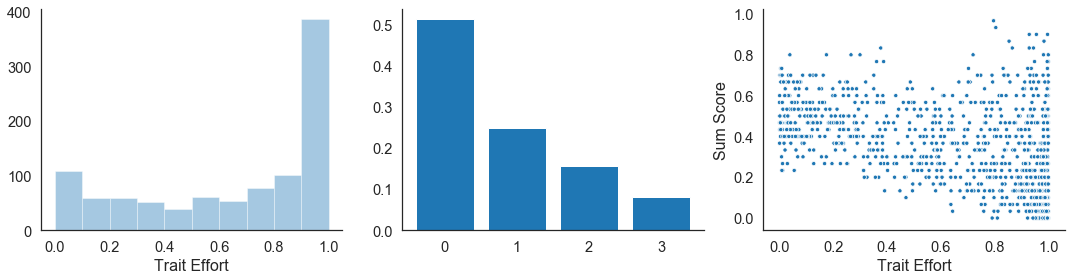

In [15]:
from scipy.stats import bernoulli, norm, skewnorm
np.random.seed(0)

## Define metadata.
n_agents = 1000
n_items = 10

## Define simulation parameters.
a = 3
b = 0.5
mu = -1

## Simulate values.
def inv_logit(arr):
    return 1. / (1 + np.exp(-arr))

phi = norm(0,1).rvs(n_agents)
phi = inv_logit( a * ( phi + b ) )
psi = norm(mu,1).rvs(n_agents)

## Compute attentive response probabilities.
tau = norm(0,1).ppf([0.17,0.50,0.83])
theta = norm(0,1).cdf(np.subtract.outer(tau, psi)).T.round(6)
theta = np.column_stack([np.zeros(n_agents), theta, np.ones(n_agents)])
theta = np.diff(theta)

## Simulate responses.
Y = np.zeros((n_agents, n_items),dtype=int)

for i in range(n_items):
    
    ## Simulate attentive repsonse.
    y_effort = np.apply_along_axis(lambda p: np.random.multinomial(1, p), 1, theta)
    y_effort = np.argmax(y_effort, axis=1)
    
    ## Simulate random response.
    y_rand = np.random.randint(0,4,n_agents)
    
    ## Store response.
    w = np.random.binomial(1, phi)
    Y[:,i] = np.where(w, y_effort, y_rand)
    
## Compute sum scores.
scores = Y.sum(axis=1) / (3 * n_items)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(15,4))

## Plot distribution of effortful responding.
sns.distplot(phi, kde=False, bins=np.linspace(0,1,11), ax=axes[0])
axes[0].set(xlabel='Trait Effort')

## Plot response likelihood.
axes[1].bar(np.arange(4), np.average(theta, axis=0, weights=phi))
axes[1].set(xticks=np.arange(4), )

## Plot distribution of sum scores.
sns.scatterplot(phi, scores, size=3, legend=False, ax=axes[2])
axes[2].set(xlabel='Trait Effort', ylabel='Sum Score')

sns.despine()
plt.tight_layout()

In [18]:
norm(0,1).cdf(np.subtract.outer(tau, psi)).T.round(6)

array([[0.304981, 0.671492, 0.918974],
       [0.198598, 0.542814, 0.855812],
       [0.680161, 0.922533, 0.991261],
       ...,
       [0.455174, 0.799985, 0.963731],
       [0.882531, 0.983899, 0.999019],
       [0.912578, 0.989583, 0.999453]])

In [20]:
tau

array([-0.95416525,  0.        ,  0.95416525])